# 02: Data Cleaning and EDA

In this notebook, we'll clean the data and do some exploratory data analysis in preparation for building our models.

There are two sections in this notebook:

* Section 1: [Data Cleaning](#cleaning)
* Section 2: [EDA](#eda) (also includes additional cleaning)

---

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('fivethirtyeight')

## <a name="cleaning"></a>Section 1: Data Cleaning

Now that the libraries are loaded, let's pull in the raw data we received from our scrape.

In [25]:
rep_df = pd.read_csv('./data/raw/raw_gop_data.csv')
dem_df = pd.read_csv('./data/raw/raw_dem_data.csv')
librt_df = pd.read_csv('./data/raw/raw_librt_data.csv')

With the data pulled in, let's look at the UTC integer as a `datetime` data type and make sure that the date ranges are what we expect.

In [26]:
# making lists of converting the created UTC integer into a datatime
rep_sub_times = rep_df['created_utc'].map(lambda x: datetime.fromtimestamp(x))
dem_sub_times = dem_df['created_utc'].map(lambda x: datetime.fromtimestamp(x))
librt_sub_times = librt_df['created_utc'].map(lambda x: datetime.fromtimestamp(x))

# printing our the ranges for submission text data
print(f'The Republican subreddit submissions are from {min(rep_sub_times)} to {max(rep_sub_times)}.')
print(f'The democrats subreddit submissions are from {min(dem_sub_times)} to {max(dem_sub_times)}.')
print(f'The Libertarian subreddit submissions are from {min(librt_sub_times)} to {max(librt_sub_times)}.')

The Republican subreddit submissions are from 2020-10-30 10:11:39 to 2020-11-29 21:32:18.
The democrats subreddit submissions are from 2020-11-07 11:00:44 to 2020-11-29 21:27:03.
The Libertarian subreddit submissions are from 2020-11-07 11:18:40 to 2020-11-29 20:49:33.


These date ranges are as expected.

Since these are moderated subreddits with consistent engagement, we'll next check if we made duplicate pulls by a taking a look at unique UTC creation dates and later double check by checking for unique IDs on each post. Check one: unique UTC creation data.

In [27]:
rep_uniq_utc = rep_df['created_utc'].unique().shape[0]
dem_uniq_utc = dem_df['created_utc'].unique().shape[0]
librt_uniq_utc = librt_df['created_utc'].unique().shape[0]

In [28]:
print(f'Number of unique created_utc (Republican): {rep_uniq_utc}')
print(f'Number of unique created_utc (Republican): {dem_uniq_utc}')
print(f'Number of unique created_utc (Republican): {librt_uniq_utc}')

Number of unique created_utc (Republican): 2996
Number of unique created_utc (Republican): 2996
Number of unique created_utc (Republican): 2999


Very few items with the same UTC data (4 or less over 3,000 posts), so a few submissions could fall within the same second over that time frame. We'll leave them in for now and move on.

Combining dataframes and selecting the subset of features for EDA and cleaning.

In [32]:
# creating combined dataframe
comb_df = pd.DataFrame()

# combining each of the three subreddit dataframes into one for processing
comb_df = comb_df.append([rep_df, dem_df, librt_df], ignore_index=True)

# creating a copy of the dataframe with the subset of features that'll be our focus
nlp_df = comb_df[['id', 'score', 'num_comments', 'subreddit', 'title', 'selftext']].copy()

nlp_df.head(3)

,id,score,num_comments,subreddit,title,selftext
0,k32h5t,1,0,Republican,Let's all do it!!!,NaN
1,k32nq5,1,9,Republican,Just like Biden: Chavez was losing on election...,NaN
2,k32ppj,1,34,Republican,Thouands of Fake Votes Found at Wisconsin Reco...,NaN


On to check number 2 for no duplicate entries: confirming unique `id` values for each entry.

In [33]:
nlp_df['id'].unique().shape

(9000,)

All submission `id` values are unique.

Let's take a quick look at the duplicate data in the `title` feature.

In [40]:
nlp_df['title'].value_counts().head()

Lol                                                                                                                        7
Thoughts?                                                                                                                  7
California State University released mega list of remote vacancies across the nation to help combat unemployment crisis    6
Exclusive: U.S. investigators were told to take 'no further action' on Caterpillar, ex-client of Barr                      4
Judge Blocks Certification of Pennsylvania Election Results                                                                4
Name: title, dtype: int64

In [39]:
nlp_df['title'].value_counts().describe()

count    8658.000000
mean        1.039501
std         0.244730
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         7.000000
Name: title, dtype: float64

Let's leave these in...with the mean, median, and Q3 all at 1 we'll not worry about this at this time. After all, perhaps people get a trend and repost the same title on purpose (or it's spam)? We'll need to revisit this for the next iteration of the model when we add more data.

Checking for `NaN`s.

In [41]:
nlp_df.isna().sum()

id                 0
score              0
num_comments       0
subreddit          0
title              0
selftext        6449
dtype: int64

All missing data in our potential feature set is in the `selftext` column.

Let's begin by seeing what values are actually there.

In [42]:
nlp_df['selftext'].value_counts().head(3)

[removed]    1195
[deleted]     146
Title.          3
Name: selftext, dtype: int64

Okay, well, the data that is actually in the column seems to be comprised of \[removed\] and \[deleted\]. What does this mean?

> [\[removed\] means it was removed by a mod or automoderator, or the spam filter, or any other Reddit "entity", really. \[deleted\] means it was deleted by the user.](https://www.reddit.com/r/modhelp/comments/48ybox/what_does_removed_mean/)

So...what to do? Let's see how this would change our data. 

We'll start by looking at the distribution of \[deleted\] across the three subreddits.

In [45]:
nlp_df[nlp_df['selftext'] == '[deleted]'][['subreddit']].value_counts()

subreddit  
democrats      67
Libertarian    54
Republican     25
dtype: int64

Democrats seem to self delete the most (followed closely by Libertarians).

What about \[removed\] items?

In [46]:
nlp_df[nlp_df['selftext'] == '[removed]'][['subreddit']].value_counts()

subreddit  
Republican     732
democrats      336
Libertarian    127
dtype: int64

Over the 3,000 posts, the Republican subreddit had just over 24% removed by a moderator or auto moderation.

That could be problematic, but hard to know why the post was removed (was it an ad? was it inflammatory? is it under review?) without more data.

Let's see if there is still data in the `title` column for these removed or deleted `selftext`s.

In [43]:
nlp_df[nlp_df['selftext'] == '[removed]'][['title']].value_counts().head()

title                                                                                            
Vote for Nick Wildstar #wildstar                                                                     4
Another Argument Against the Voter Fraud Narrative                                                   4
Would You Guys Fill Out This Form? It's For a School Project. Thanks!                                3
Honest Question                                                                                      2
Petition to Reverse the Biden Legacy of mass incarceration, endless wars, and spying on Americans    2
dtype: int64

In [44]:
nlp_df[nlp_df['selftext'] == '[deleted]'][['title']].value_counts().head()

title                                                                                                                  
California State University released mega list of remote vacancies across the nation to help combat unemployment crisis    3
Donald Trump WWE Moments From History                                                                                      2
💃🏽                                                                                                                         1
How Kelly Loeffler Went From Atlanta Elite to Trump Loyalist                                                               1
I'm not a democrat, but..                                                                                                  1
dtype: int64

All these rows still have data in the `title` and though there are some duplicates, we'll leave them in for now for the reasons mentioned previously.

One last check here before we move on: Are there any rows where `title` is either \[removed\] or \[deleted\]? 

In [52]:
nlp_df[nlp_df['title'] == '[removed]']

,id,score,num_comments,subreddit,title,selftext


In [48]:
nlp_df[nlp_df['title'] == '[deleted]']

,id,score,num_comments,subreddit,title,selftext


Since no `title` data is has been marked \[removed\] or \[deleted\], we'll use what we've got.

With so many missing values in `selftext`, let's clean these out by combining the `title` and `selftext` columns into one `all_text` column for eventual natural language processing.

We'll start by filling in the `NaN` with a blank space, then replacing the \[removed\] and \[deleted\] text strings with a empty space as well. These empty spaces will enable us to merge the two text fields without any errors since they will create a string value rather than a `NaN` in the appropriate data fields.

In [53]:
# filling NaN values with a blank space
nlp_df['selftext'].fillna(' ', inplace=True)

# creating  list of values to replace before replacing them
missing = ['[removed]', '[deleted]']
nlp_df['selftext'] = nlp_df['selftext'].map(lambda x: ' ' if x in missing else x)

# checking for NaN values
nlp_df.isna().sum()

id              0
score           0
num_comments    0
subreddit       0
title           0
selftext        0
dtype: int64

All `NaN`s are cleared.

Next, we'll combine `title` and `selftext` into the new column `all_text` for vectorizing.

In [54]:
# creating new column and filling it with concatenated text from `title` and `selftext`
nlp_df['all_text'] = nlp_df['title'] + ' ' + nlp_df['selftext']

# stripping any extra spaces added in the process
nlp_df['all_text'] = nlp_df['all_text'].map(lambda x: x.strip())

Let's take a quick look at what we've got:

In [55]:
nlp_df.head()

,id,score,num_comments,subreddit,title,selftext,all_text
0,k32h5t,1,0,Republican,Let's all do it!!!,,Let's all do it!!!
1,k32nq5,1,9,Republican,Just like Biden: Chavez was losing on election...,,Just like Biden: Chavez was losing on election...
2,k32ppj,1,34,Republican,Thouands of Fake Votes Found at Wisconsin Reco...,,Thouands of Fake Votes Found at Wisconsin Reco...
3,k32qff,1,0,Republican,Why has the media not called this out yet. hmmmm,,Why has the media not called this out yet. hmmmm
4,k32z48,1,0,Republican,If Biden Gets Sworn In Do Democrats Switch The...,,If Biden Gets Sworn In Do Democrats Switch The...


Now let's engineer two additional features:
* `text_length`: a length of the entire text string (including spaces)
* `rough_word_count`: a count of the number "words" after splitting the text at each space

These two columns may give us some additional information and inform our predictions.

In [57]:
# creating text length feature (length of the `all_text` string)
nlp_df['text_length'] = nlp_df['all_text'].map(lambda x: len(x))

# count of "words" after splitting the string at each space
nlp_df['rough_word_count'] = nlp_df['all_text'].map(lambda x: len(x.split()))

One last confirmation of our distribution of the number of posts for each subreddit.

In [58]:
nlp_df['subreddit'].value_counts()

democrats      3000
Republican     3000
Libertarian    3000
Name: subreddit, dtype: int64

---

## <a name="eda"></a>Section 2: EDA

Let's start by looking at the results of our engineered features for each of the subreddits.

In [59]:
nlp_df.groupby('subreddit')[['text_length', 'rough_word_count']].mean()

,text_length,rough_word_count
subreddit,,
Libertarian,326.812667,53.528667
Republican,67.563000,11.323000
democrats,80.608667,13.658000


Wow, the `text_length` and `rough_word_count` values for Libertarians are markedly higher than those for Democrats and Republicans.

This could indicate a deeper level of sharing and engagement for Libertarians on Reddit.

Where are this much greater text values coming from?

In [60]:
nlp_df[nlp_df['selftext'] > ' '].groupby('subreddit')[['selftext']].count()

,selftext
subreddit,
Libertarian,1132
Republican,23
democrats,41


Ah, `selftext`. Over 1/3 of all Libertarian posts contain some `selftext`. This is ~49x greater than that of Republicans. But remember, a lot of Republican submissions had their `selftext` \[removed\] or \[deleted\] (over 750). Democrats had just over 400 \[removed\] or \[deleted\] `subtexts` , and Libertarians 181.

Even considering these \[removed\] or \[deleted\] `selftext` values, Libertarians would still outpace both Republicans and Democrats on `selftext`. Does this have to do with ideology (of posters and moderators)? The fact that the Republicans and Democrats are part of our country's two-party system and there is simply more need for moderation both by users and moderators? I have no idea, but questions to keep in mind as we move forward both with this initial exploration and any future development  

Let's use `CountVectorizer` for a closer look at individual words... 

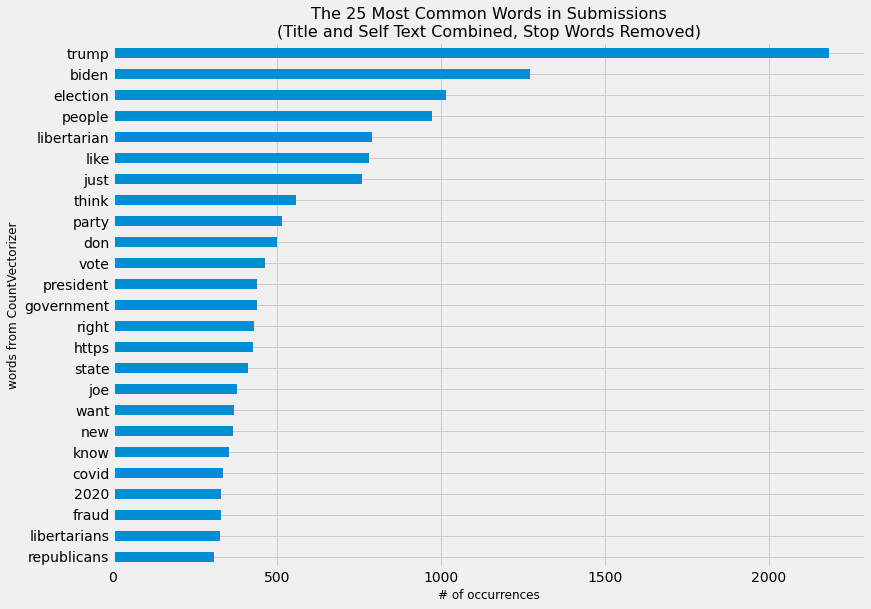

In [62]:
# creating a new dataframe
all_text_series = nlp_df['all_text'].copy()

# instantiating CountVectorizer() removing standard stop words and
# limiting the vectorizer to creating vectors for words that appear in at least 25 submissions
countvec = CountVectorizer(stop_words='english', min_df=25)

# fitting and transforming the vectorizer
countvec_sparse = countvec.fit_transform(all_text_series)

# creating a data frame to hold the results
countvec_df = pd.DataFrame(countvec_sparse.todense(), columns=countvec.get_feature_names())

# graphing the top 25 words
countvec_df.sum().sort_values(ascending=True).tail(25).plot(kind='barh', figsize=(12,9))
plt.title('The 25 Most Common Words in Submissions\n(Title and Self Text Combined, Stop Words Removed)', size=16)
plt.xlabel('# of occurrences', size=12)
plt.ylabel('words from CountVectorizer', size=12);

Unsurprisingly, the single word vectors with the most occurrences are centered around the recent US election (candidates names / 2020 / election / vote / fraud / political parties & ideologies).

Also noticing the 'https' -- clearly people are sharing links. We'll need to see how that shows up in our data.

To take a deeper dive, let's connect the vectorized word features to our original data.

In [63]:
# putting the CountVectorizer with other data for EDA
# creating a copy to leave our original data intact
eda_df = nlp_df[['id', 'subreddit', 'title', 'selftext', 'text_length', 'rough_word_count']].copy()

# merging the vectorized features with our original data
eda_df = eda_df.merge(countvec_df, left_index=True, right_index=True, suffixes=(None, '_y'))

# creating a list of the word features
word_features = list(eda_df.columns)[6:]

Now that all the data is together, let's look at the top 10 words found for each subreddit.

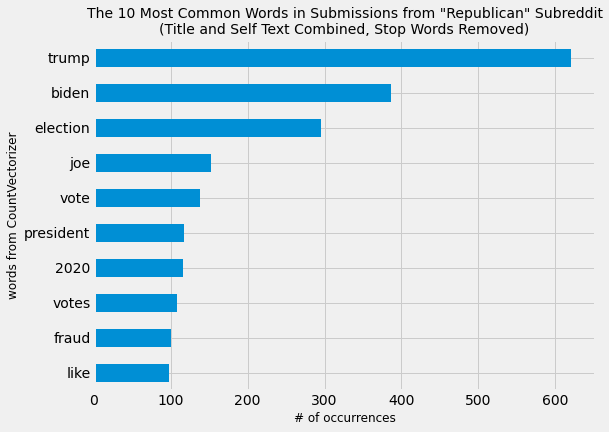

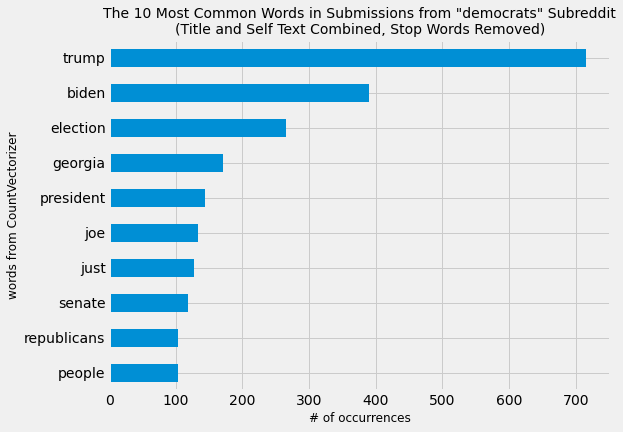

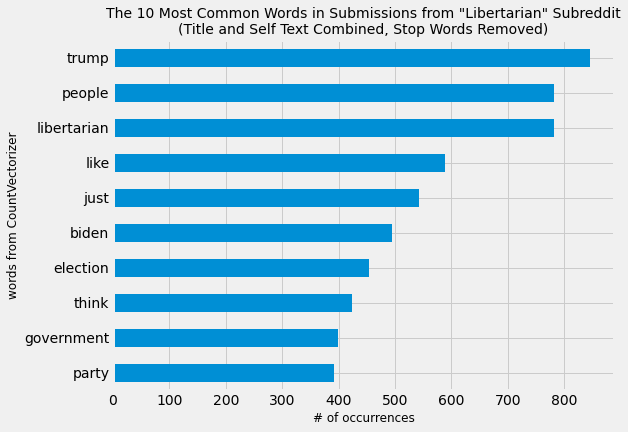

In [64]:
# Graphing the top 10 words using a for loop
subreddits = ['Republican', 'democrats', 'Libertarian']

for subreddit in subreddits:
    plt.figure(figsize=(8,6))
    eda_df[eda_df['subreddit'] == subreddit][word_features].sum().sort_values(ascending=True).tail(10).plot(kind='barh')
    plt.title(f'The 10 Most Common Words in Submissions from "{subreddit}" Subreddit\n(Title and Self Text Combined, Stop Words Removed)', size=14)
    plt.xlabel('# of occurrences', size=12)
    plt.ylabel('words from CountVectorizer', size=12);

A lot of the same words at the top...will need to try bi- and trigrams as well as looking at the differences differences for my model.

Now to clean up the links in the data. I want to get rid of the useless bits, but keep the source info as they may help with determining the subreddit of a post, but that may be too much processing at this point for too little data.

Let's see...we'll start by building a function pull out the first link it finds in text using regex.

Then we'll create a new `url` feature to hold the value found by function and map the function to the new column using the data in the `all_text` column as input.

In [66]:
# with thanks for the regex to: https://stackoverflow.com/questions/839994/extracting-a-url-in-python
def get_url(text):
    try:
        return re.search("(?P<url>https?://[^\s'\"]+)", text).group("url")
    except:
        return ' '


nlp_df['url'] = nlp_df['all_text'].map(get_url)

Now let's take a look at what subreddits contain at least one url.

In [67]:
nlp_df[nlp_df['url']> ' '].groupby('subreddit')[['subreddit']].count()

,subreddit
subreddit,
Libertarian,143
Republican,13
democrats,16


The subreddit with most url's in their submissions is Libertarians. However, with each subreddit having 3,000 posts, I'm not sure that it's worth parsing these url's.

Before we decide, let's take a look at what parsing them looks like.

We'll do the following:
* create a pointer to the rows with a value in `url`, 
* create a list of simple, web address-related words to remove,
* vectorize the `url` values, and
* see what we get by graphing the top 25 resulting "words".

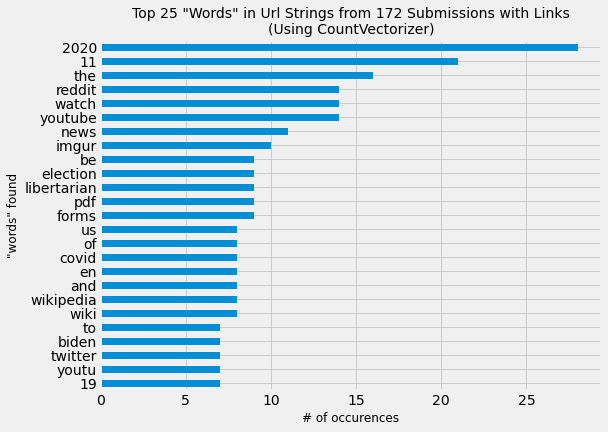

In [71]:
# creating the pointer to the rows with data in 'url'
url_df = nlp_df[nlp_df['url'] > ' '][['url']]

# simple custom stop words list
additional_stop_words = ['https', 'http', 'www', 'com', 'org', 'net', 'comments', 'amp', 'gov', 'html']

# firing up the CountVectorizer
url_ctvec = CountVectorizer(stop_words=additional_stop_words)
url_ctvec_sparse = url_ctvec.fit_transform(url_df['url'])
url_ctvec_df = pd.DataFrame(url_ctvec_sparse.todense(), columns=url_ctvec.get_feature_names())

# graphing the results
plt.figure(figsize=(8,6))
url_ctvec_df.sum().sort_values().tail(25).plot(kind='barh')
plt.title('Top 25 "Words" in Url Strings from 172 Submissions with Links\n(Using CountVectorizer)', size = 14)
plt.xlabel('# of occurrences', size=12)
plt.ylabel('"words" found', size=12);

With so few occurrences of words and so many words that would be dropped eventually, let's let these submissions go.

In [72]:
print(f'Shape of data frame pre-drop: {nlp_df.shape}')

# dropping submissions with urls
nlp_df = nlp_df[nlp_df['url'] == ' '].copy()

print(f'Shape of data frame post-drop: {nlp_df.shape}')

Shape of data frame pre-drop: (9000, 10)
Shape of data frame post-drop: (8828, 10)


All rows with data in `url` have been successfully dropped. Now we'll get rid of the `url` column and take a look at the resulting distribution of our submissions by subreddit.

In [73]:
nlp_df.drop(columns=['url'], inplace=True)

nlp_df[['subreddit']].value_counts(normalize=True)

subreddit  
Republican     0.338355
democrats      0.338015
Libertarian    0.323629
dtype: float64

### Top Bigrams and Trigrams (URLs removed)

The next two charts will take a look at the top 15 bigrams and trigrams to see 

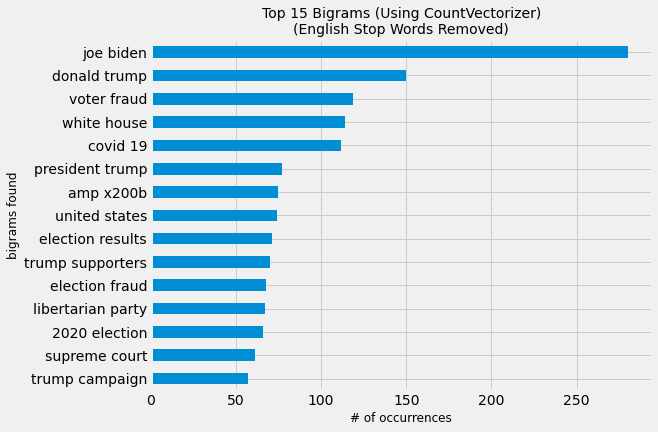

In [76]:
# firing up the CountVectorizer to create bigrams
bigrams_ctvec = CountVectorizer(stop_words='english', ngram_range=(2, 2))
bigrams_ctvec_sparse = bigrams_ctvec.fit_transform(nlp_df['all_text'])
bigrams_ctvec_df = pd.DataFrame(bigrams_ctvec_sparse.todense(), columns=bigrams_ctvec.get_feature_names())

# plotting the results
plt.figure(figsize=(8,6))
bigrams_ctvec_df.sum().sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 Bigrams (Using CountVectorizer)\n(English Stop Words Removed)', size = 14)
plt.xlabel('# of occurrences', size=12)
plt.ylabel('bigrams found', size=12);

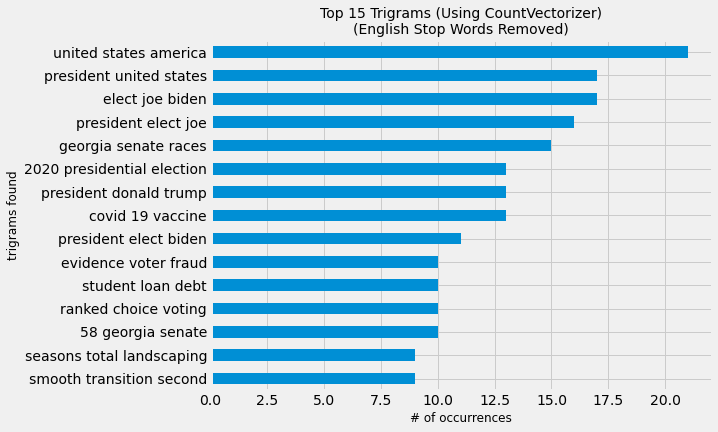

In [77]:
# firing up the CountVectorizer to create trigrams
trigrams_ctvec = CountVectorizer(stop_words='english', ngram_range=(3, 3))
trigrams_ctvec_sparse = trigrams_ctvec.fit_transform(nlp_df['all_text'])
trigrams_ctvec_df = pd.DataFrame(trigrams_ctvec_sparse.todense(), columns=trigrams_ctvec.get_feature_names())

# plotting the results
plt.figure(figsize=(8,6))
trigrams_ctvec_df.sum().sort_values().tail(15).plot(kind='barh')
plt.title('Top 15 Trigrams (Using CountVectorizer)\n(English Stop Words Removed)', size = 14)
plt.xlabel('# of occurrences', size=12)
plt.ylabel('trigrams found', size=12);

Nothing too surprising here -- with the bigram and trigram 'phrases' clearly related to the current political climate and recent election. It is interesting to note the dropping max occurrence frequencies as we increase from single to bi- to trigram. It'll be interesting to see how the modeling grid search optimizes over n_gram parameters. 

While our goal is to use natural language processing to analyze text to predict the classification of a post, there are some additional numeric features that could potentially inform and aid our predictive power (especially if the future use was to limited to Reddit).

What follows are some quick statistical descriptions of how each of these numeric features are expressed in each category.

In [84]:
print(' ')
print('Breakdown of "score" by Subreddit')
nlp_df.groupby('subreddit')[['score']].describe()

 
Breakdown of Score by Subreddit


score                                                   
              count       mean         std  min  25%  50%  75%     max
subreddit                                                             
Libertarian  2857.0  10.238362  190.810031  0.0  1.0  1.0  1.0  7997.0
Republican   2987.0   1.486106    7.689211  0.0  1.0  1.0  1.0   292.0
democrats    2984.0   8.438338   78.188154  0.0  1.0  1.0  1.0  1977.0

In [85]:
print(' ')
print('Breakdown of "num_comments" by Subreddit')
nlp_df.groupby('subreddit')[['num_comments']].describe()

 
Breakdown of "num_comments" by Subreddit


num_comments                                                     
                   count       mean         std  min  25%   50%   75%     max
subreddit                                                                    
Libertarian       2857.0  44.735387  160.802293  0.0  2.0  12.0  35.0  3781.0
Republican        2987.0   9.462337   34.594176  0.0  0.0   1.0   5.0   670.0
democrats         2984.0   6.102547   21.406797  0.0  0.0   2.0   4.0   417.0

In [86]:
print(' ')
print('Breakdown of "text_length" by Subreddit')
nlp_df.groupby('subreddit')[['text_length']].describe()

 
Breakdown of "text_length" by Subreddit


text_length                                                  \
                  count        mean         std  min   25%   50%    75%   
subreddit                                                                 
Libertarian      2857.0  265.850193  495.843977  3.0  62.0  95.0  247.0   
Republican       2987.0   64.889856   74.610659  1.0  27.0  52.0   81.0   
democrats        2984.0   77.839142  115.648871  1.0  32.0  59.0   92.0   

                     
                max  
subreddit            
Libertarian  8205.0  
Republican   1448.0  
democrats    3109.0

In [87]:
print(' ')
print('Breakdown of "rough_word_count" by Subreddit')
nlp_df.groupby('subreddit')[['rough_word_count']].describe()

 
Breakdown of "rough_word_count" by Subreddit


rough_word_count                                               \
                       count       mean        std  min   25%   50%   75%   
subreddit                                                                   
Libertarian           2857.0  45.191460  84.913769  1.0  10.0  15.0  41.0   
Republican            2987.0  10.995983  13.124219  1.0   5.0   9.0  13.0   
democrats             2984.0  13.298257  20.675928  1.0   6.0  10.0  15.0   

                     
                max  
subreddit            
Libertarian  1222.0  
Republican    256.0  
democrats     569.0

We've already talked about `text_length` and `rough_word_count` earlier. Those earlier observations still hold true even after losing some of the Libertarian submissions.

The new information for us to consider is `score` and `num_comments`.

The `score` variances are led by extreme scores on a small subset of submissions with Q1-Q3 values at 1 for all three subreddits.

As for `num_comments`, the mean values for Libertarians again far outpace Democrats and Republicans. This holds true for Q1-Q3. This would indicate that the Libertarian community is particularly engaged on Reddit.

It's time to get the data ready for modeling. Here's what we'll do:
* Drop the columns we definitely not use in our modeling.
* Reorder our columns (for aesthetic reasons and ease of use)
* Map our `subreddit` values from string to numeric {'Republican':0, 'democrats':1, 'Libertarian':2}

In [90]:
# drop unnecessary columns
nlp_df.drop(columns=['id', 'title', 'selftext'], inplace=True)

# reorder columns
nlp_df =  nlp_df[['score', 'num_comments', 'text_length', 
                  'rough_word_count', 'all_text', 'subreddit']]

# map numeric values to each categorical string in `subreddit`
nlp_df['subreddit'] = nlp_df['subreddit'].map({'Republican':0, 'democrats':1, 'Libertarian':2})

Finally, we'll export the data for use in our modeling.

In [91]:
nlp_df.to_csv('./data/political_subreddit_clean.csv', index=False)